## Comparison of OLPS strategies using pyolps

In this notebook we will compare most popular OLPS strategies implemented in pyolps package on 5 datasets that are widely used for measuring OLPS performance: NYSE(O), NYSE(N), DJIA, MSCI and SP-500. The algorithms under consideration are:

1) Bechmarks:
- Buy and Hold (BAH) with random weights
- Uniform BAH (UBAH)
- Constant Rebalanced Portfolio (CRP) with random weights
- Uniform CRP (UCRP)
- Best Constant Rebalanced Portfolio (BCRP)
- Best Stock

2) Follow-the-Winner:
- Universal Portfolio (UP)
- Exponential Gradient (EG)
- Online Newton Step (ONS)

3) Follow-the-Loser:
- Anti Correlation (Anticor) in 2 variants: BAH(Anticor) and BAH(Anticor(Anticor))
- Passive Aggressive Mean Reversion (PAMR)
- Online Moving Average Reversion (OLMAR) in 2 variants: OLMAR-1 and OLMAR-2
- Robust Median Reversion (RMR)

4) Pattern-Matching Approaches:
- Nonparametric Nearest Neighbor Log-optimal (BNN)
- Correlation-driven Nonparametric Learning

In [10]:
import numpy as np
import pandas as pd

from scipy import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

In [9]:
from pyolps import utils
from pyolps.strategy import *

In [221]:
def convert_ratio_to_price(data_ratio):
    data_price = np.ones(data_ratio.shape)
    for i in range(1, data_ratio.shape[0]):
        data_price[i] = data_price[i - 1] * data_ratio[i]
    return data_price


def load_results(path_part, str_adding):
    cumprod = np.load(path_part + ('cumprod_ret%s.npy' % str_adding))
    daily_ret = np.load(path_part + ('daily_ret%s.npy' % str_adding))
    daily_portfolio = np.load(path_part + ('daily_portfolio%s.npy' % str_adding))
    res = (cumprod[-1], cumprod, daily_ret, daily_portfolio)
    return res


def plot_data(data, title='', figsize=(12, 10), ylabel=''):
    plt.figure(figsize=figsize)
    for i in range(data.shape[1]):
        plt.plot(data[:, i], label= 'stock ' + str(i))
        
    plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(color='lightgray', linestyle='dashed')
    plt.title(title, size=20)
    plt.ylabel(ylabel, size=15)
    plt.xlabel('time', size=15)
    plt.show()


def plot_results(results, strategy_set=None, figsize=(12, 10), title='', 
                 semilogy_flag=False, lw=2):
    if semilogy_flag:
        plot_func = plt.semilogy
    else:
        plot_func = plt.plot
    
    plt.figure(figsize=figsize)
    
    for strategy_name, res in results.items():
        if strategy_set is not None:
            if not strategy_name in strategy_set:
                continue
        plot_func(res[1], label=strategy_name, lw=lw)

    plt.title(title, size=20)
    plt.xlabel("Time", size=15)
    ylabel = 'Total Return'
    if semilogy_flag:
        ylabel += ' (log-scale)'
    plt.ylabel(ylabel, size=15)
    plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(color='lightgray', linestyle='dashed')
    plt.show()

### NYSE(O) dataset

First of all, let's test the strategies on NYSE(O) (New York Stock Exchange) dataset. This dataset contains 36 US assets for 5651 days starting from 3/7/1962 to 31/12/1984.

In [103]:
data_ratio_nyseo = io.loadmat('data/nyse-o.mat')['data']
data_prices_nyseo = convert_ratio_to_price(data_ratio_nyseo)

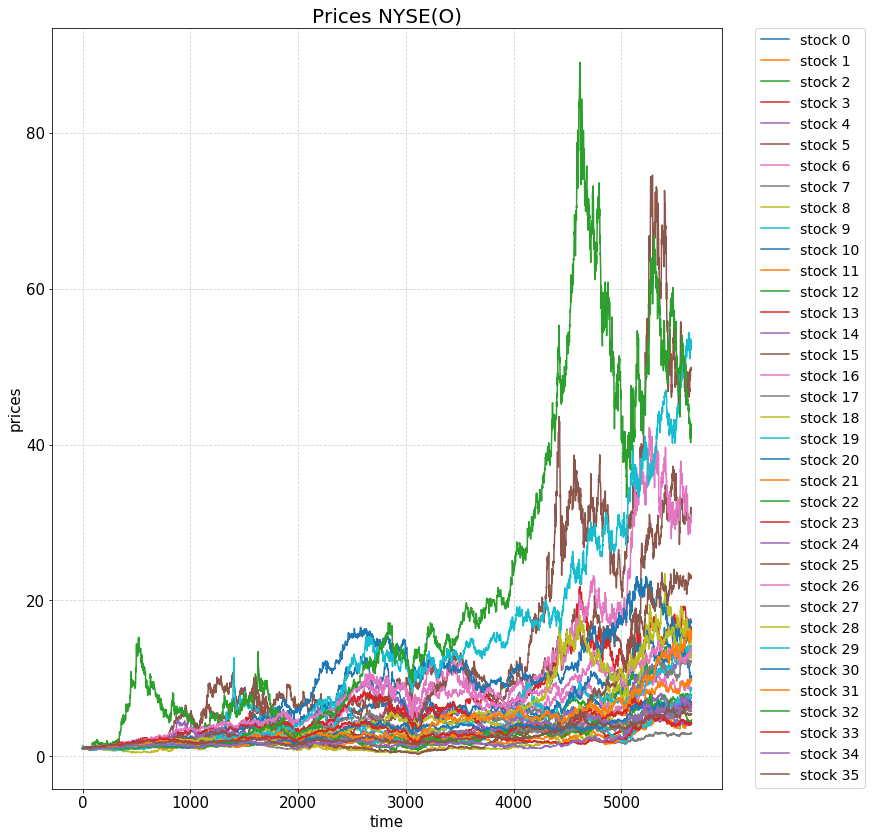

In [105]:
plot_data(data_prices_nyseo, "Prices NYSE(O)", (12, 14), 'prices')

Let's consider zero transaction costs and default parameters of strategies (parameters that were proposed by authors of algorithms to perform well).

In [15]:
tc = 0.
opts = {'display_interval': 1000}

In [17]:
random_weights = np.random.rand(data_ratio_nyseo.shape[1])
random_weights = random_weights / np.sum(random_weights)

In [18]:
res_bah = bah.bah_run(data_ratio_nyseo, tc, opts, random_weights)
res_ubah = bah.bah_run(data_ratio_nyseo, tc, opts)

res_bcrp = bcrp.bcrp_run(data_ratio_nyseo, tc, opts)
res_best = best_stock.best_stock_run(data_ratio_nyseo, tc, opts)

res_crp = crp.crp_run(data_ratio_nyseo, tc, opts, random_weights)
res_ucrp = crp.crp_run(data_ratio_nyseo, tc, opts)

res_up = up.up_run(data_ratio_nyseo, tc, opts, verbose=True)

  0%|          | 18/5651 [00:00<00:32, 174.59it/s]

Parameters [tc: 0.000000].

day	 Daily Return	 Total return



 18%|█▊        | 1007/5651 [00:15<01:13, 63.60it/s]

1000	1.004669	2.272758



 35%|███▌      | 2003/5651 [00:44<01:21, 44.86it/s]

2000	0.987786	3.144524



 53%|█████▎    | 3002/5651 [01:36<01:25, 31.05it/s]

3000	0.970673	5.276974



 71%|███████   | 4001/5651 [02:58<01:13, 22.36it/s]

4000	0.992139	8.884382



 88%|████████▊ | 5001/5651 [05:34<00:43, 14.93it/s]

5000	0.996458	14.369515



100%|██████████| 5651/5651 [07:34<00:00, 12.43it/s]


In [41]:
res_eg = eg.eg_run(data_ratio_nyseo, tc, opts)
res_ons = ons.ons_run(data_ratio_nyseo, tc, opts)

100%|██████████| 5651/5651 [00:44<00:00, 125.64it/s]


In [69]:
res_olmar1 = olmar.olmar_run(data_ratio_nyseo, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2 = olmar.olmar_run(data_ratio_nyseo, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr = rmr.rmr_run(data_ratio_nyseo, tc, opts, epsilon=10, window=5)

100%|██████████| 5651/5651 [00:19<00:00, 286.84it/s]


In [60]:
res_anticor = anticor.anticor_run(data_ratio_nyseo, tc, opts)
res_anticor_anticor = anticor.anticor_anticor_run(data_ratio_nyseo, tc, opts)

100%|██████████| 5651/5651 [03:52<00:00, 24.34it/s]


In [64]:
res_pamr = pamr.pamr_run(data_ratio_nyseo, tc, opts)

100%|██████████| 5651/5651 [00:01<00:00, 3138.89it/s]


As it takes pretty long time to compute CORN (48 minutes) and BNN (8 hours) strategies, I've computed them once and saved the results in order not to recompute them each time. Let's load the results:

In [121]:
res_corn = load_results('saved_results/', '_corn_nyseo')
res_bnn = load_results('saved_results/', '_bnn_nyseo')

In [122]:
results_nyseo = {
    'BAH': res_bah, 'UBAH': res_ubah, 'BCRP': res_bcrp, 'Best Stock': res_best,
    'CRP': res_crp, 'UCRP': res_ucrp, 'UP': res_up, 'EG': res_eg,
    'ONS': res_ons, 'Anticor': res_anticor, 'Anticor(Anticor)': res_anticor_anticor,
    'PAMR': res_pamr, 'OLMAR-1': res_olmar1, 'OLMAR-2': res_olmar2,
    'RMR': res_rmr, 'CORN': res_corn, 'BNN': res_bnn
}

Let's plot the results:

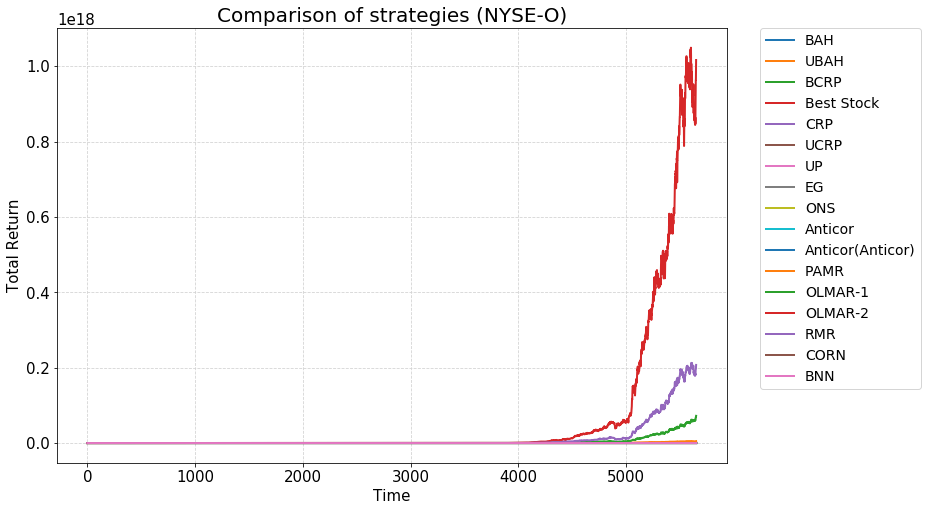

In [124]:
plot_results(results_nyseo, figsize=(12, 8), title="Comparison of strategies (NYSE-O)")

The same with log-scaled Y axis:

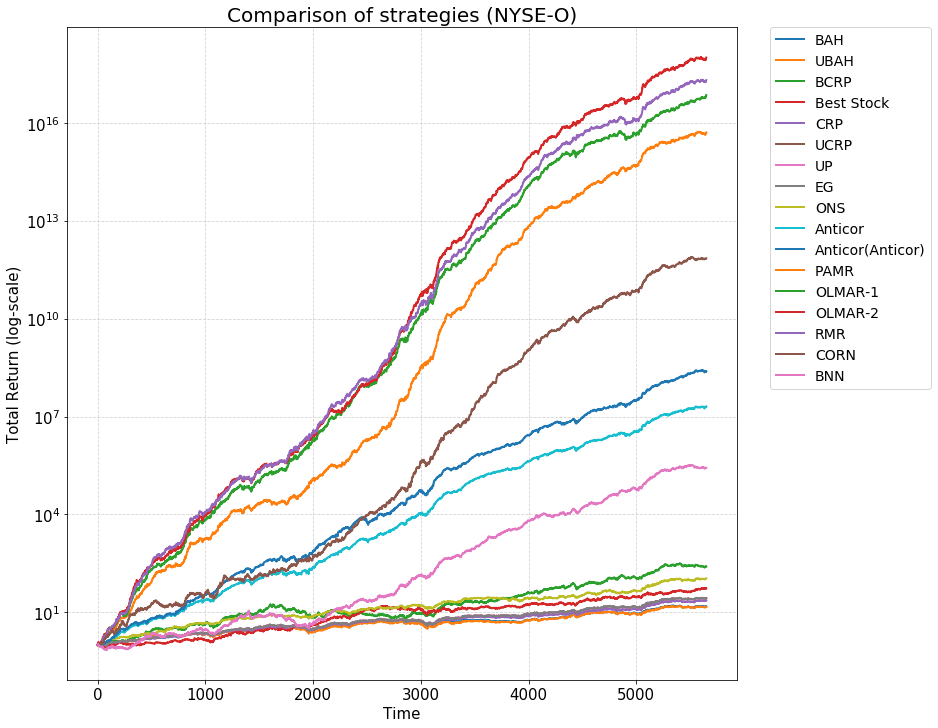

In [125]:
plot_results(results_nyseo, figsize=(12, 12), title="Comparison of strategies (NYSE-O)",
             semilogy_flag=True)

We can see that the best performance has OLMAR-2 strategy. Then we have CRP, OLMAR-1, PAMR, CORN, BAH(Anticor(Anticor)), BAH(Anticor) and BNN strategies (listed in the order of descending final return). All these strategies perform better than BCRP.

Now let's look at strategies that are worse than BCRP closer:

In [106]:
worse_bcrp_names = {'BAH', 'UBAH', 'BCRP', 'Best Stock', 'CRP', 'UCRP', 'UP', 'EG', 'ONS'}

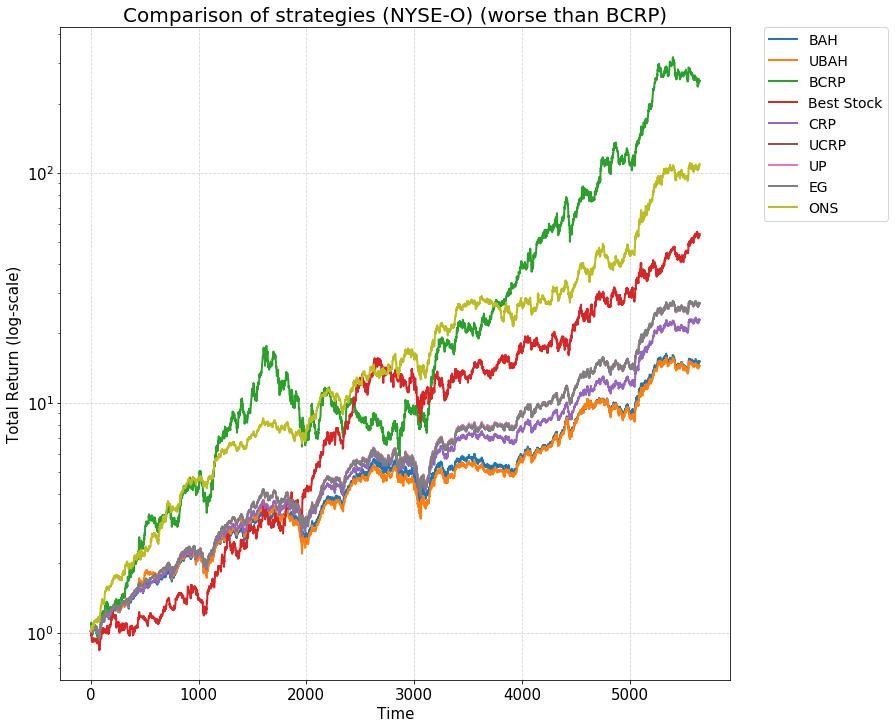

In [116]:
plot_results(results_nyseo, worse_bcrp_names, figsize=(12, 12), 
             title="Comparison of strategies (NYSE-O) (worse than BCRP)", semilogy_flag=True)

We can see that even though ONS doesn't beat the BCRP, it still beats the Best Stock. All other algorithms doesn't beat the Best Stock. UP, EG and UCRP have almost the same quality. CRP and BAH with randomly generated weights and UBAH have the lowest quality. Also, BAH with random weights performs slightly better than UBAH - how lucky we are!

### NYSE(N) dataset

Now let's test the strategies on NYSE(N) dataset. This dataset contains 23 US assets for 6431 days starting from 1/1/1985 to 30/6/2010.

In [145]:
import h5py

In [146]:
contents = {}
with h5py.File('data/nyse-n.mat', 'r') as f:
    for k, v in f.items():
        contents[k] = np.array(v)
data_ratio_nysen = contents['data'].T
data_prices_nysen = convert_ratio_to_price(data_ratio_nysen)

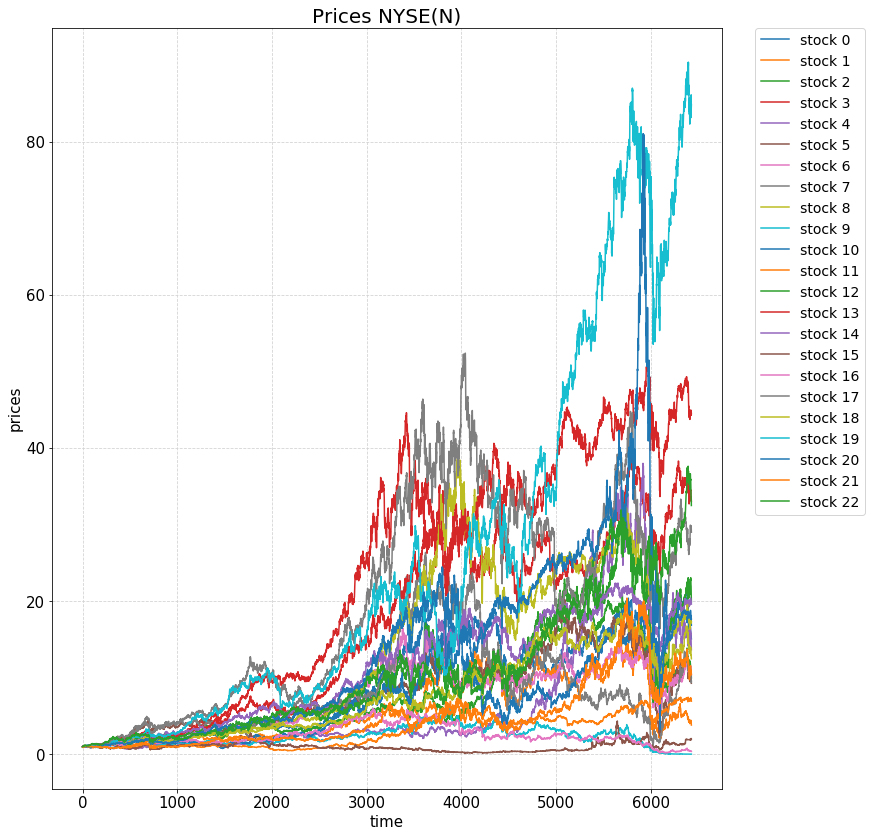

In [147]:
plot_data(data_prices_nysen, "Prices NYSE(N)", (12, 14), 'prices')

In [160]:
random_weights_nysen = np.random.rand(data_ratio_nysen.shape[1])
random_weights_nysen = random_weights_nysen / np.sum(random_weights_nysen)

In [161]:
res_bah_nysen = bah.bah_run(data_ratio_nysen, tc, opts, random_weights_nysen)
res_ubah_nysen = bah.bah_run(data_ratio_nysen, tc, opts)

100%|██████████| 6431/6431 [00:00<00:00, 18636.44it/s]


In [162]:
res_bcrp_nysen = bcrp.bcrp_run(data_ratio_nysen, tc, opts)

100%|██████████| 6431/6431 [00:00<00:00, 22200.67it/s]


In [163]:
res_best_nysen = best_stock.best_stock_run(data_ratio_nysen, tc, opts)
res_crp_nysen = crp.crp_run(data_ratio_nysen, tc, opts, random_weights_nysen)
res_ucrp_nysen = crp.crp_run(data_ratio_nysen, tc, opts)

100%|██████████| 6431/6431 [00:00<00:00, 23171.94it/s]


In [164]:
res_up_nysen = up.up_run(data_ratio_nysen, tc, opts)
res_eg_nysen = eg.eg_run(data_ratio_nysen, tc, opts)
res_ons_nysen = ons.ons_run(data_ratio_nysen, tc, opts)
res_olmar1_nysen = olmar.olmar_run(data_ratio_nysen, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2_nysen = olmar.olmar_run(data_ratio_nysen, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr_nysen = rmr.rmr_run(data_ratio_nysen, tc, opts, epsilon=10, window=5)
res_anticor_nysen = anticor.anticor_run(data_ratio_nysen, tc, opts)
res_anticor_anticor_nysen = anticor.anticor_anticor_run(data_ratio_nysen, tc, opts)
res_pamr_nysen = pamr.pamr_run(data_ratio_nysen, tc, opts)

100%|██████████| 6431/6431 [00:02<00:00, 2947.10it/s]


In [172]:
res_corn_nysen = load_results('saved_results/', '_corn_nysen')

In [173]:
results_nysen = {
    'BAH': res_bah_nysen, 'UBAH': res_ubah_nysen, 'BCRP': res_bcrp_nysen, 
    'Best Stock': res_best_nysen, 'CRP': res_crp_nysen, 'UCRP': res_ucrp_nysen, 
    'UP': res_up_nysen, 'EG': res_eg_nysen, 'ONS': res_ons_nysen,
    'Anticor': res_anticor_nysen, 'Anticor(Anticor)': res_anticor_anticor_nysen,
    'PAMR': res_pamr_nysen, 'OLMAR-1': res_olmar1_nysen, 'OLMAR-2': res_olmar2_nysen,
    'RMR': res_rmr_nysen, 'CORN': res_corn_nysen
}

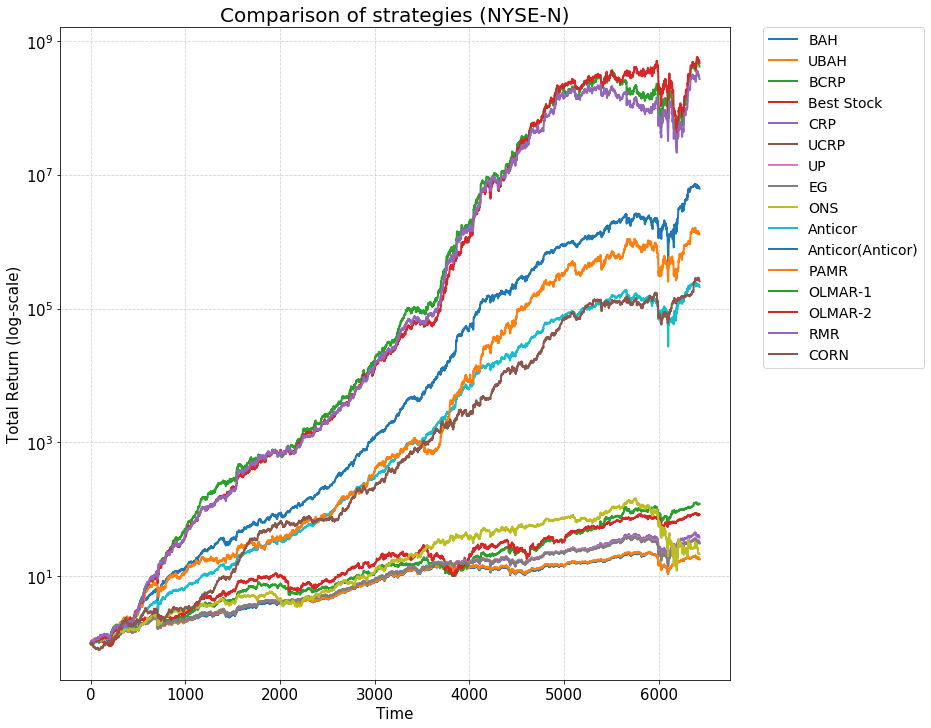

In [174]:
plot_results(results_nysen, figsize=(12, 12), title="Comparison of strategies (NYSE-N)",
             semilogy_flag=True)

All in all we have similar results as before: we have 3 groups of algorithms: high quality (OLMAR-2, RMR, OLMAR-1), medium quality (Anticor(Anticor), PAMR, Anticor, CORN) and ordinary quality (the ones that are lower than BCRP).

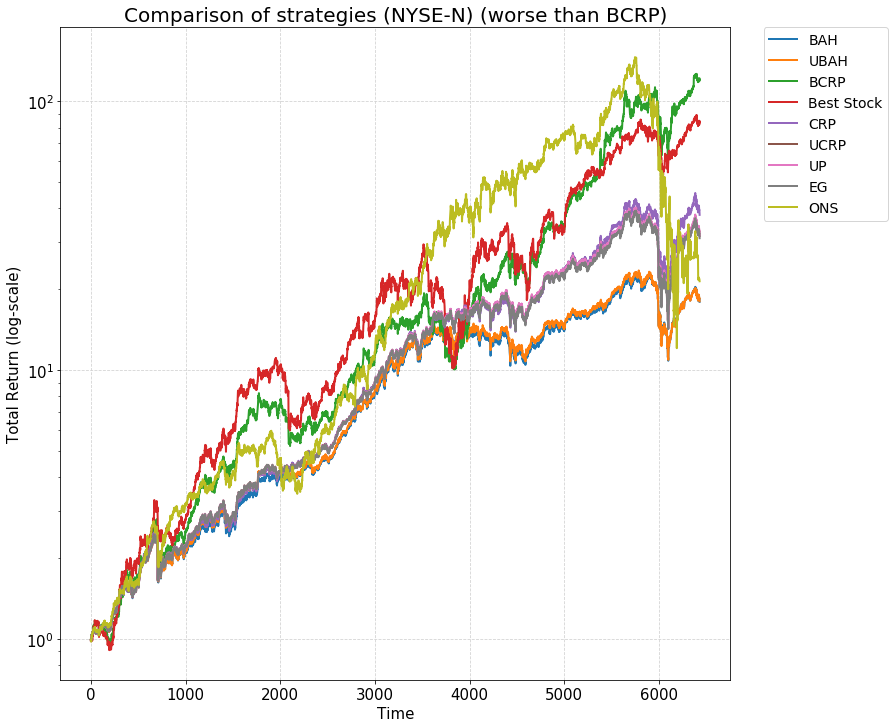

In [175]:
plot_results(results_nysen, worse_bcrp_names, figsize=(12, 12), 
             title="Comparison of strategies (NYSE-N) (worse than BCRP)", semilogy_flag=True)

### DJIA dataset

DJIA (Dow Jones Industrial Average) dataset contains 30 US assets for 507 days starting from 1/1/2001 to 14/1/2003.

In [177]:
data_ratio_dja = io.loadmat('data/djia.mat')['data']
data_prices_dja = convert_ratio_to_price(data_ratio_dja)

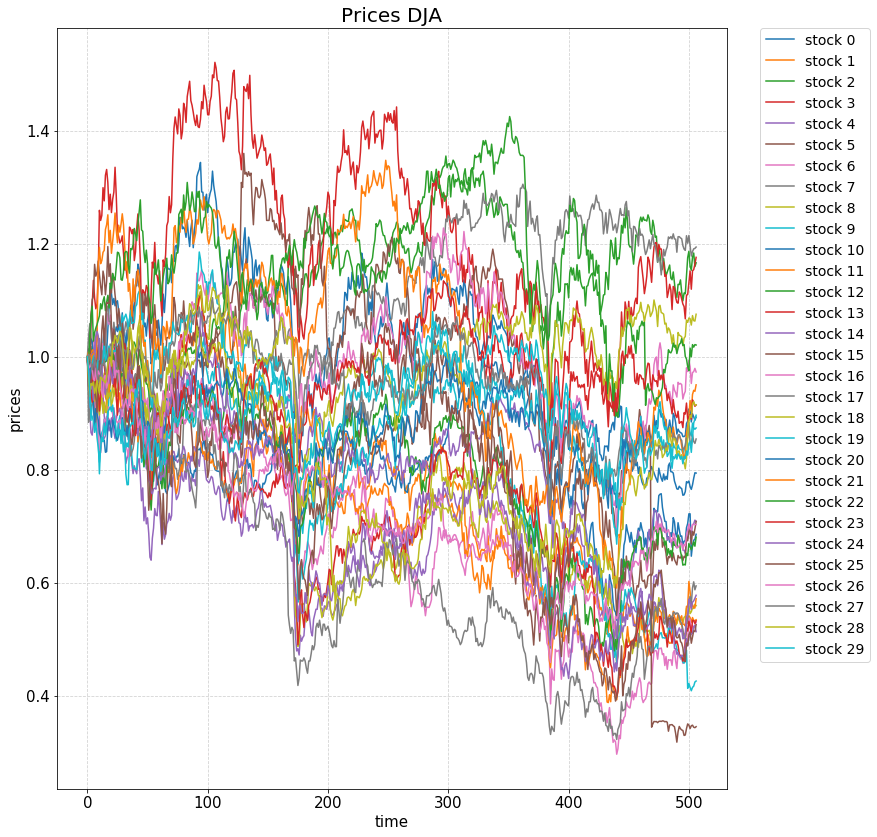

In [178]:
plot_data(data_prices_dja, "Prices DJA", (12, 14), 'prices')

In [181]:
random_weights_dja = np.random.rand(data_ratio_dja.shape[1])
random_weights_dja = random_weights_dja / np.sum(random_weights_dja)

In [183]:
res_bah_dja = bah.bah_run(data_ratio_dja, tc, opts, random_weights_dja)
res_ubah_dja = bah.bah_run(data_ratio_dja, tc, opts)
res_bcrp_dja = bcrp.bcrp_run(data_ratio_dja, tc, opts)
res_best_dja = best_stock.best_stock_run(data_ratio_dja, tc, opts)
res_crp_dja = crp.crp_run(data_ratio_dja, tc, opts, random_weights_dja)
res_ucrp_dja = crp.crp_run(data_ratio_dja, tc, opts)
res_up_dja = up.up_run(data_ratio_dja, tc, opts)
res_eg_dja = eg.eg_run(data_ratio_dja, tc, opts)
res_ons_dja = ons.ons_run(data_ratio_dja, tc, opts)
res_olmar1_dja = olmar.olmar_run(data_ratio_dja, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2_dja = olmar.olmar_run(data_ratio_dja, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr_dja = rmr.rmr_run(data_ratio_dja, tc, opts, epsilon=10, window=5)
res_anticor_dja = anticor.anticor_run(data_ratio_dja, tc, opts)
res_anticor_anticor_dja = anticor.anticor_anticor_run(data_ratio_dja, tc, opts)
res_pamr_dja = pamr.pamr_run(data_ratio_dja, tc, opts)
res_corn_dja = corn.corn_run(data_ratio_dja, tc, opts)

100%|██████████| 507/507 [00:33<00:00, 15.09it/s]


In [185]:
res_bnn_dja = bnn.bnn_run(data_ratio_dja, tc, opts)

100%|██████████| 507/507 [14:15<00:00,  1.69s/it]


In [207]:
results_dja = {
    'BAH': res_bah_dja, 'UBAH': res_ubah_dja, 'BCRP': res_bcrp_dja, 'Best Stock': res_best_dja,
    'CRP': res_crp_dja, 'UCRP': res_ucrp_dja, 'UP': res_up_dja, 'EG': res_eg_dja,
    'ONS': res_ons_dja, 'Anticor': res_anticor_dja, 'Anticor(Anticor)': res_anticor_anticor_dja,
    'PAMR': res_pamr_dja, 'OLMAR-1': res_olmar1_dja, 'OLMAR-2': res_olmar2_dja,
    'RMR': res_rmr_dja, 'CORN': res_corn_dja, 'BNN': res_bnn_dja
}

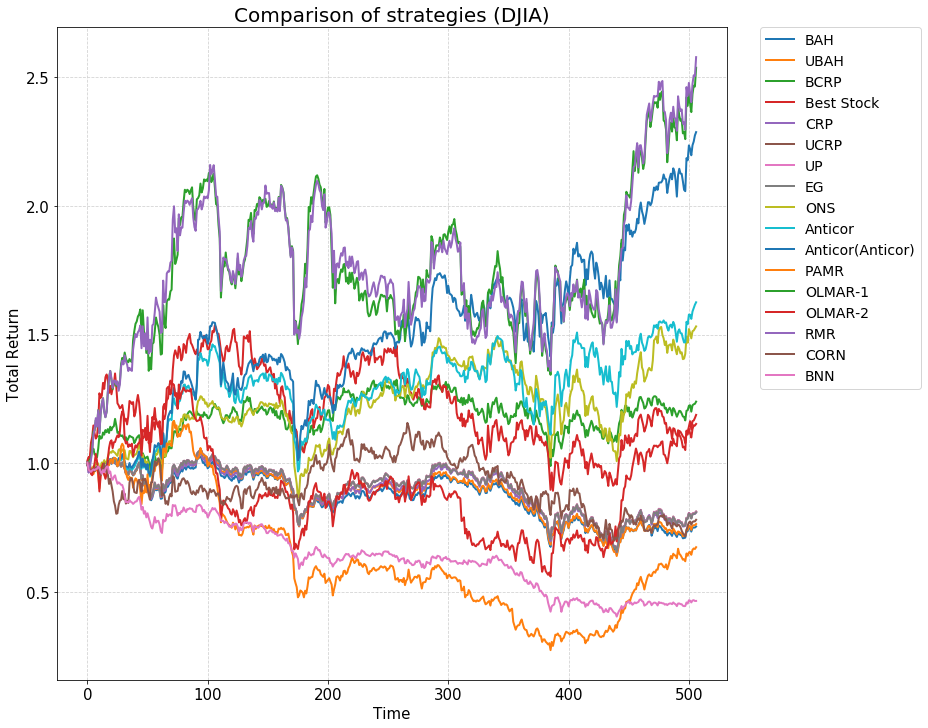

In [199]:
plot_results(results_dja, figsize=(12, 12), title="Comparison of strategies (DJIA)",
             semilogy_flag=False)

In [214]:
worse_bcrp_names_dja = {'BAH', 'UBAH', 'BCRP', 'Best Stock', 'CRP', 'UCRP', 'UP', 'EG',
                       'BNN', 'PAMR', 'OLMAR-2', 'CORN'}

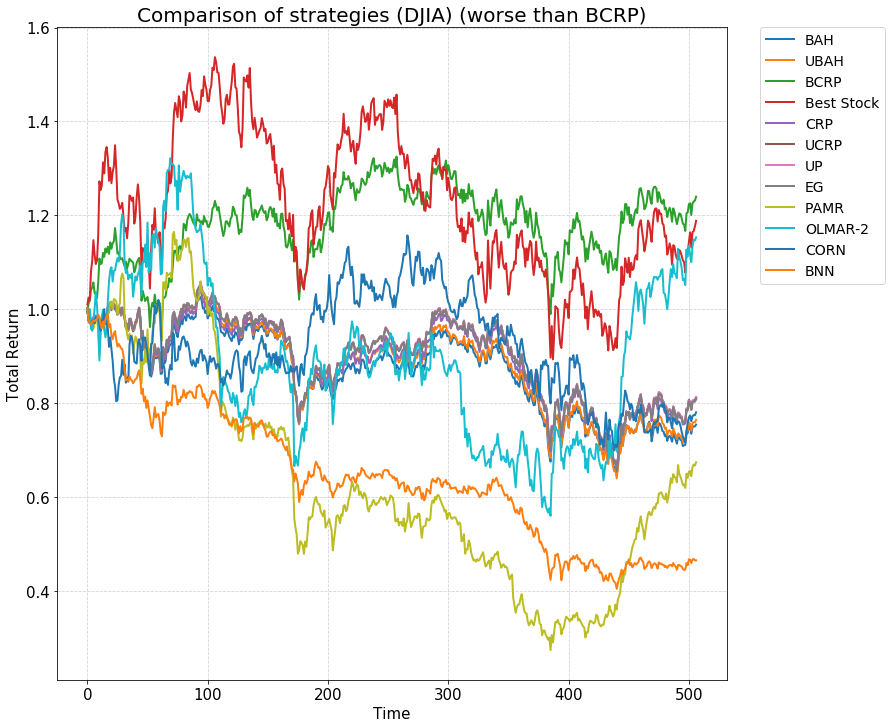

In [215]:
plot_results(results_dja, worse_bcrp_names_dja, figsize=(12, 12), 
             title="Comparison of strategies (DJIA) (worse than BCRP)", semilogy_flag=False)

We can see that in case of DJIA dataset the situation changes. Now the best performance has RMR and OLMAR-1 strategies, but OLMAR-2 fails to beat BCRP and Best Stock. Anticor(Anticor), Anticor still show good performance and ONS - medium performance. However, unlike before BNN, CORN and PAMR show bad performance (return < 1). BAH, UBAH, UP, EG, CRP, UCRP all perform similarly and have low quality (return < 1).

### MSCI dataset

MSCI (Morgan Stanley Capital International) dataset contains 24 global assets for 1043 days starting from 1/4/2006 to 31/3/2010.

In [200]:
data_ratio_msci = io.loadmat('data/msci.mat')['data']
data_prices_msci = convert_ratio_to_price(data_ratio_msci)

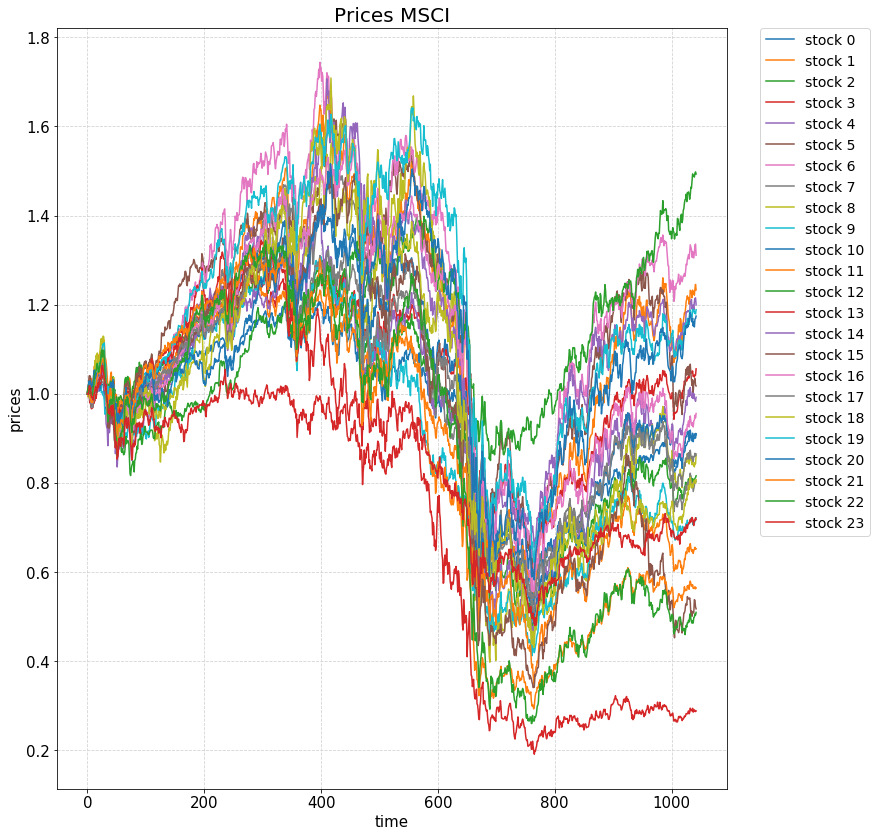

In [201]:
plot_data(data_prices_msci, "Prices MSCI", (12, 14), 'prices')

In [203]:
random_weights_msci = np.random.rand(data_ratio_msci.shape[1])
random_weights_msci = random_weights_msci / np.sum(random_weights_msci)

In [204]:
res_bah_msci = bah.bah_run(data_ratio_msci, tc, opts, random_weights_msci)
res_ubah_msci = bah.bah_run(data_ratio_msci, tc, opts)
res_bcrp_msci = bcrp.bcrp_run(data_ratio_msci, tc, opts)
res_best_msci = best_stock.best_stock_run(data_ratio_msci, tc, opts)
res_crp_msci = crp.crp_run(data_ratio_msci, tc, opts, random_weights_msci)
res_ucrp_msci = crp.crp_run(data_ratio_msci, tc, opts)
res_up_msci = up.up_run(data_ratio_msci, tc, opts)
res_eg_msci = eg.eg_run(data_ratio_msci, tc, opts)
res_ons_msci = ons.ons_run(data_ratio_msci, tc, opts)
res_olmar1_msci = olmar.olmar_run(data_ratio_msci, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2_msci = olmar.olmar_run(data_ratio_msci, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr_msci = rmr.rmr_run(data_ratio_msci, tc, opts, epsilon=10, window=5)
res_anticor_msci = anticor.anticor_run(data_ratio_msci, tc, opts)
res_anticor_anticor_msci = anticor.anticor_anticor_run(data_ratio_msci, tc, opts)
res_pamr_msci = pamr.pamr_run(data_ratio_msci, tc, opts)
res_corn_msci = corn.corn_run(data_ratio_msci, tc, opts)

100%|██████████| 1043/1043 [02:06<00:00,  8.26it/s]


In [206]:
results_msci = {
    'BAH': res_bah_msci, 'UBAH': res_ubah_msci, 'BCRP': res_bcrp_msci, 
    'Best Stock': res_best_msci, 'CRP': res_crp_msci, 'UCRP': res_ucrp_msci, 
    'UP': res_up_msci, 'EG': res_eg_msci, 'ONS': res_ons_msci, 
    'Anticor': res_anticor_msci, 'Anticor(Anticor)': res_anticor_anticor_msci,
    'PAMR': res_pamr_msci, 'OLMAR-1': res_olmar1_msci, 'OLMAR-2': res_olmar2_msci,
    'RMR': res_rmr_msci, 'CORN': res_corn_msci
}

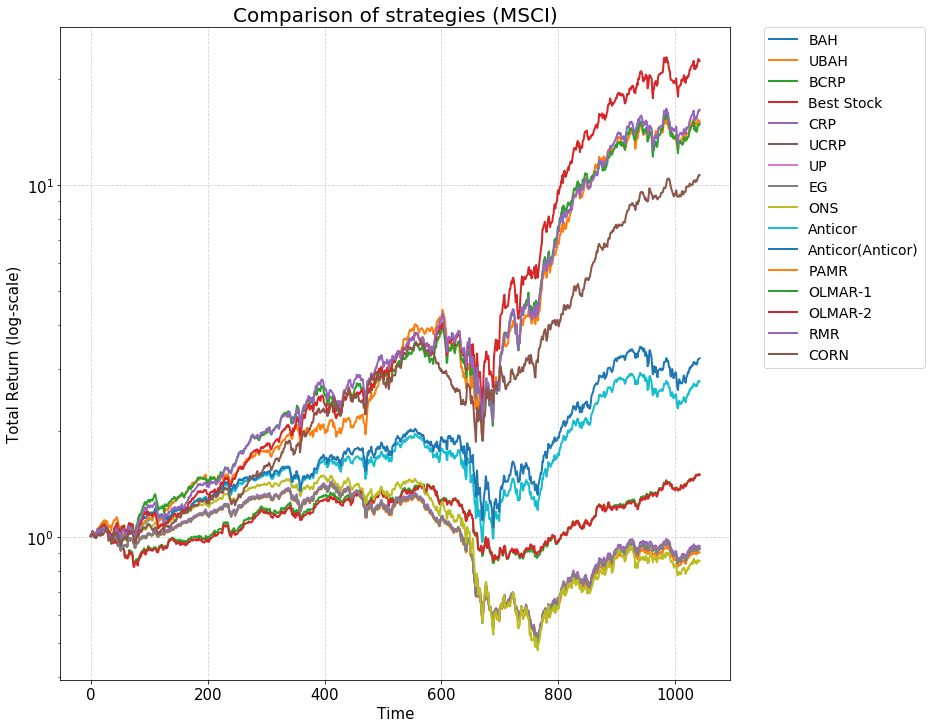

In [213]:
plot_results(results_msci, figsize=(12, 12), title="Comparison of strategies (MSCI)",
             semilogy_flag=True)

In [234]:
worse_bcrp_names_msci = {'BAH', 'UBAH', 'BCRP', 'Best Stock', 'CRP', 'UCRP', 'UP', 'EG', 'ONS'}

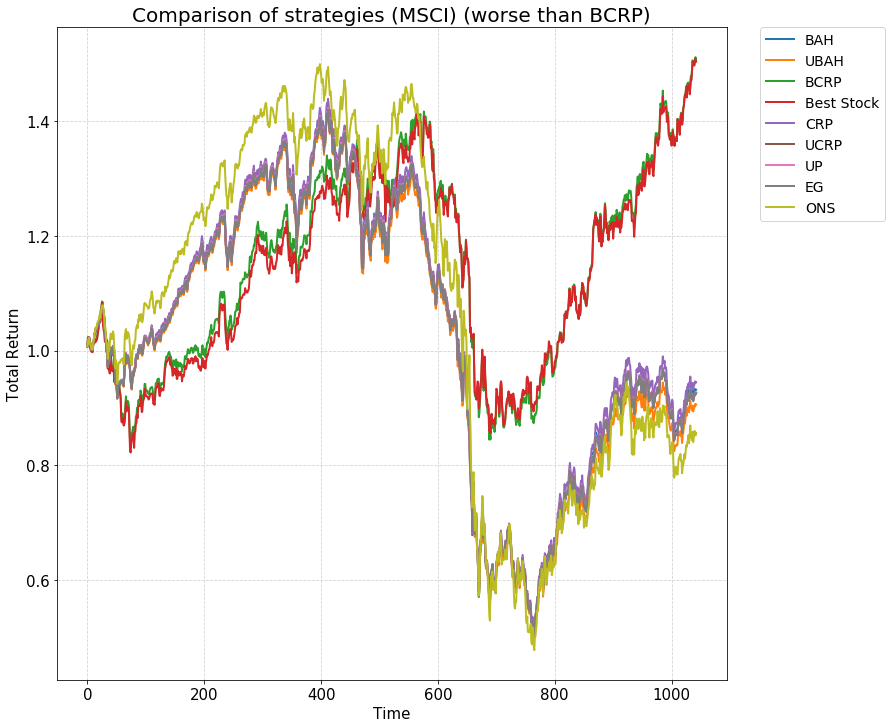

In [235]:
plot_results(results_msci, worse_bcrp_names_msci, figsize=(12, 12), 
             title="Comparison of strategies (MSCI) (worse than BCRP)", semilogy_flag=False)

In case of MSCI dataset the relative positions of algorithms are similar to NYSE datasets.

### SP-500

SP-500 dataset contains 25 assets for 1276 days from 2/1/1998 to 31/1/2003.

In [219]:
data_ratio_sp500 = io.loadmat('data/sp500.mat')['data']
data_prices_sp500 = convert_ratio_to_price(data_ratio_sp500)

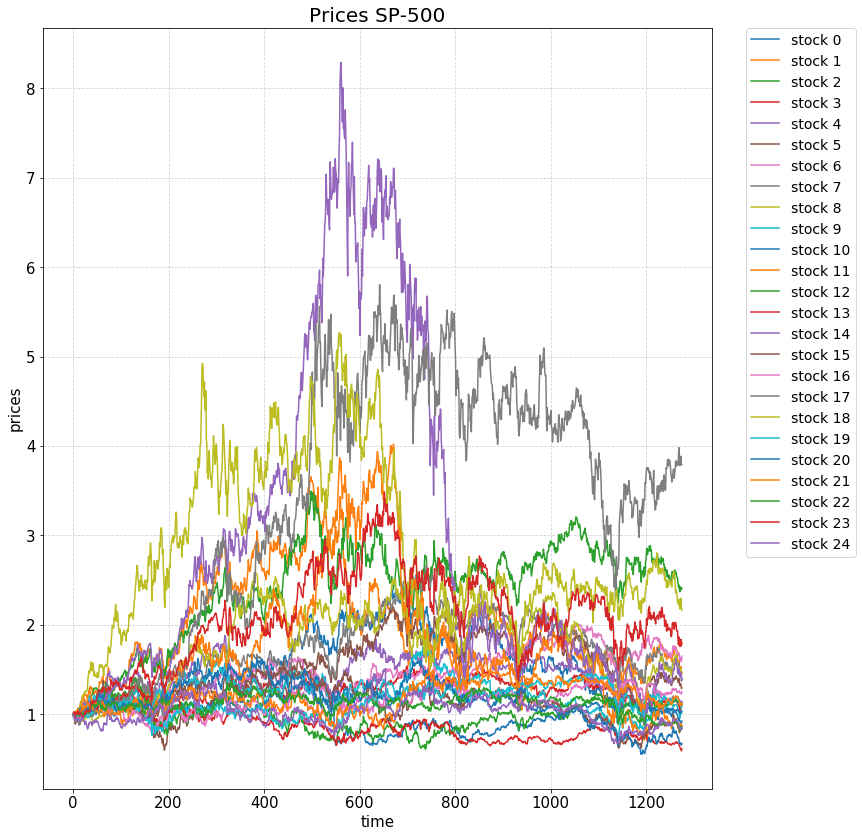

In [222]:
plot_data(data_prices_sp500, "Prices SP-500", (12, 14), 'prices')

In [223]:
random_weights_sp500 = np.random.rand(data_ratio_sp500.shape[1])
random_weights_sp500 = random_weights_sp500 / np.sum(random_weights_sp500)

In [224]:
res_bah_sp500 = bah.bah_run(data_ratio_sp500, tc, opts, random_weights_sp500)
res_ubah_sp500 = bah.bah_run(data_ratio_sp500, tc, opts)
res_bcrp_sp500 = bcrp.bcrp_run(data_ratio_sp500, tc, opts)
res_best_sp500 = best_stock.best_stock_run(data_ratio_sp500, tc, opts)
res_crp_sp500 = crp.crp_run(data_ratio_sp500, tc, opts, random_weights_sp500)
res_ucrp_sp500 = crp.crp_run(data_ratio_sp500, tc, opts)
res_up_sp500 = up.up_run(data_ratio_sp500, tc, opts)
res_eg_sp500 = eg.eg_run(data_ratio_sp500, tc, opts)
res_ons_sp500 = ons.ons_run(data_ratio_sp500, tc, opts)
res_olmar1_sp500 = olmar.olmar_run(data_ratio_sp500, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2_sp500 = olmar.olmar_run(data_ratio_sp500, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr_sp500 = rmr.rmr_run(data_ratio_sp500, tc, opts, epsilon=10, window=5)
res_anticor_sp500 = anticor.anticor_run(data_ratio_sp500, tc, opts)
res_anticor_anticor_sp500 = anticor.anticor_anticor_run(data_ratio_sp500, tc, opts)
res_pamr_sp500 = pamr.pamr_run(data_ratio_sp500, tc, opts)
res_corn_sp500 = corn.corn_run(data_ratio_sp500, tc, opts)

100%|██████████| 1276/1276 [02:36<00:00,  8.17it/s]


In [226]:
results_sp500 = {
    'BAH': res_bah_sp500, 'UBAH': res_ubah_sp500, 'BCRP': res_bcrp_sp500, 
    'Best Stock': res_best_sp500, 'CRP': res_crp_sp500, 'UCRP': res_ucrp_sp500, 
    'UP': res_up_sp500, 'EG': res_eg_sp500, 'ONS': res_ons_sp500, 
    'Anticor': res_anticor_sp500, 'Anticor(Anticor)': res_anticor_anticor_sp500,
    'PAMR': res_pamr_sp500, 'OLMAR-1': res_olmar1_sp500, 'OLMAR-2': res_olmar2_sp500,
    'RMR': res_rmr_sp500, 'CORN': res_corn_sp500
}

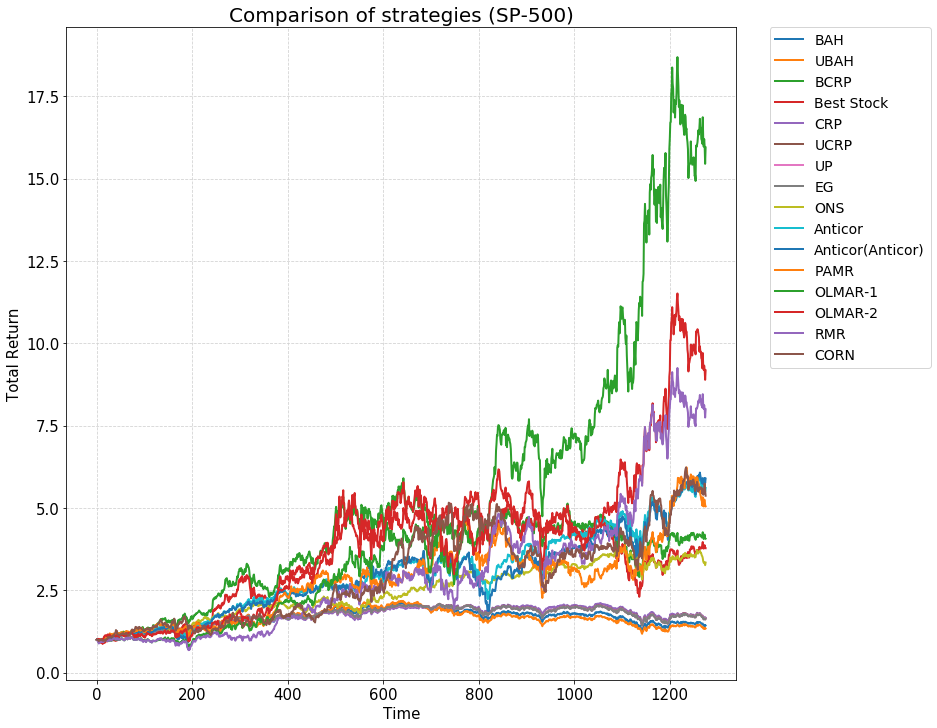

In [237]:
plot_results(results_sp500, figsize=(12, 12), title="Comparison of strategies (SP-500)",
             semilogy_flag=False)

In [231]:
worse_bcrp_names_sp500 = {'BAH', 'UBAH', 'BCRP', 'Best Stock', 'CRP', 'UCRP', 'UP', 'EG', 'ONS'}

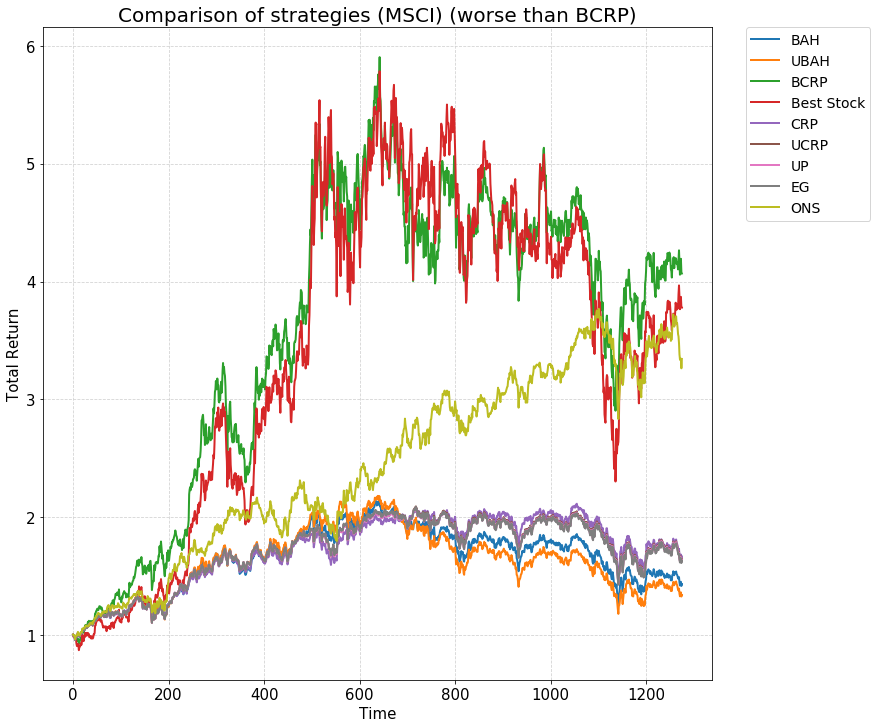

In [232]:
plot_results(results_sp500, worse_bcrp_names_sp500, figsize=(12, 12), 
             title="Comparison of strategies (MSCI) (worse than BCRP)", semilogy_flag=False)

We see that in case of SP-500 dataset relative positions of strategies are similar to NYSE dataset.

## Final Results

In [243]:
strategies_names = list(results_nyseo.keys())

In [240]:
final_results = {
    "NYSE(O)": results_nyseo,
    "NYSE(N)": results_nysen,
    "DJIA": results_dja,
    "MSCI": results_msci,
    "SP-500": results_sp500
}

In [261]:
def aggregate_results(final_results, strategies_names):
    res = {}
    for dataset_name, dataset_result in final_results.items():
        result = []
        for strategy_name in strategies_names:
            if strategy_name in dataset_result:
                result.append(dataset_result[strategy_name][0])
            else:
                result.append('-')
        res[dataset_name] = result
    res['Methods'] = strategies_names
    return pd.DataFrame(res)[['Methods', 'NYSE(O)', 'NYSE(N)', 'DJIA', 'MSCI', 'SP-500']]

In [262]:
final_results_df = aggregate_results(final_results, strategies_names)

We get final results (due to time costs BNN was computed for NYSE(O) and DJIA):

In [268]:
final_results_df

Methods       NYSE(O)      NYSE(N)      DJIA      MSCI   SP-500
0                BAH  1.511987e+01      17.9695  0.754662  0.932014  1.43463
1               UBAH  1.449731e+01      18.0565  0.764361  0.906352  1.34164
2               BCRP  2.505971e+02      120.321  1.239928   1.50569  4.06863
3         Best Stock  5.414036e+01      83.5067  1.188360   1.50402  3.77918
4                CRP  2.294723e+01      37.8549  0.808490  0.945381  1.66869
5               UCRP  2.707525e+01      31.5517  0.812726  0.926836  1.64871
6                 UP  2.708672e+01      31.8012  0.812531  0.927351  1.64231
7                 EG  2.709489e+01      31.0001  0.810030  0.926016  1.63332
8                ONS  1.092776e+02      21.4319  1.532288   0.85641  3.34376
9            Anticor  2.041028e+07       210611  1.625955   2.77467  5.60967
10  Anticor(Anticor)  2.409719e+08  6.20291e+06  2.287164   3.22125  5.89265
11              PAMR  5.162701e+15  1.28631e+06  0.674283   15.1141  5.05159
12           OLMAR-1  7.214918e+16  4.13678e+08  2.537232   14.9353  15.9435
13           OLMAR-2  1.016344e+18  4.73341e+08  1.153302   22.5277  9.17663
14               RMR  2.072557e+17  2.69871e+08  2.578588   16.3603  7.99505
15              CORN  7.144528e+11       255922  0.780679   10.6626  5.37243
16               BNN  2.686234e+05            -  0.465470         -        -

## Conclusions

We have compared several OLPS strategies on 5 datasets. Based on the results we can make such conclusions:
- Follow-the-Loser algorithms have the best performance;
- Pattern-Matching approaches have medium performance (except DJIA dataset);
- BAH(Anticor(Anticor)) is better than BAH(Anticor)) in most cases;
- BAH and UBAH have the poorest performance;
- CRP, UCRP UP, EG perform very similar to each other and the performance is not high;
- in all cases BAH, UBAH, CRP, UCRP UP, EG are worse than the Best Stock and BCRP;
- in all cases OLMAR-1, RMR, Anticor and Anticor(Anticor) are better than the Best Stock and BCRP.